Cluster 0:  strap, guitar, locks, leather, straps, button, guitars, just, fit, lock
Cluster 1:  guitar, use, just, works, does, good, like, price, dont, mic
Cluster 2:  pedal, amp, delay, sound, just, pedals, use, good, distortion, board
Cluster 3:  strings, string, guitar, sound, dont, like, little, good, just, use
Cluster 4:  picks, pick, guitar, dunlop, use, holder, lose, like, dont, mm

Top Terms for Each Cluster:
Cluster 0:  strap, guitar, locks, leather, straps, button, guitars, just, fit, lock
Cluster 1:  guitar, use, just, works, does, good, like, price, dont, mic
Cluster 2:  pedal, amp, delay, sound, just, pedals, use, good, distortion, board
Cluster 3:  strings, string, guitar, sound, dont, like, little, good, just, use
Cluster 4:  picks, pick, guitar, dunlop, use, holder, lose, like, dont, mm

Number of Reviews in Each Cluster:
1    677
3    103
2     76
0     60
4     54
Name: cluster, dtype: int64

Sentiment Distribution Within Clusters:
sentiment  negative
cluster        

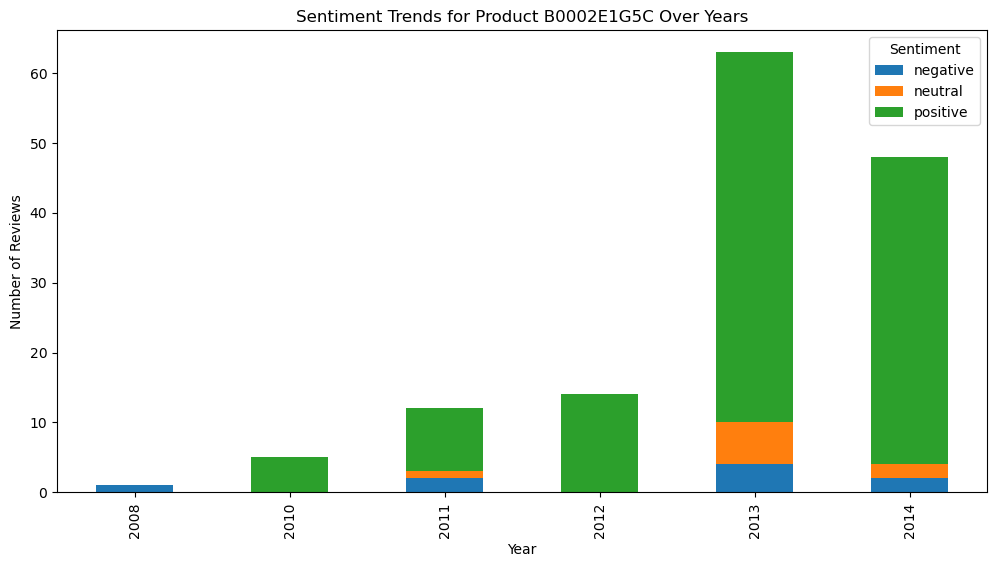

           polarity  subjectivity
count  10261.000000  10261.000000
mean       0.247015      0.533104
std        0.194675      0.146841
min       -0.800000      0.000000
25%        0.127692      0.453636
50%        0.228125      0.529647
75%        0.354167      0.610185
max        1.000000      1.000000

Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.10      0.17       229
     neutral       0.00      0.00      0.00        58
    positive       0.87      1.00      0.93      1766

    accuracy                           0.87      2053
   macro avg       0.51      0.37      0.37      2053
weighted avg       0.82      0.87      0.82      2053


Top Keywords in Negative Reviews:
[('the', 3594), ('i', 2237), ('a', 2062), ('it', 1842), ('to', 1838), ('and', 1808), ('of', 1071), ('is', 1003), ('this', 977), ('for', 882), ('on', 762), ('with', 759), ('that', 744), ('my', 726), ('but', 719), ('you', 690), ('in', 642), ('have', 609), 

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter
import re
import matplotlib.pyplot as plt
from textblob import TextBlob

# Initialize sentiment analyzers
sid = SentimentIntensityAnalyzer()

# Load the processed dataset
file_path = '/Users/dinabandhupanigrahi/customer-sentiment-dashboard/data/processed/Musical_Instruments_cleaned.csv'
df = pd.read_csv(file_path)

# Precompute additional variables
df['review_length'] = df['reviewText'].fillna('').apply(len)  # Review length
df['reviewText'] = df['reviewText'].fillna('').astype(str)    # Ensure text is string

# Sentiment Scores and Classification
df['sentiment_score'] = df['reviewText'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_score'].apply(
    lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral'
)

# Filter negative reviews
negative_reviews = df[df['sentiment'] == 'negative'].copy()

# Vectorize text for clustering and topic modeling
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(negative_reviews['reviewText'])

# Cluster using KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(tfidf_matrix)
negative_reviews['cluster'] = km.labels_

# Display top terms for each cluster
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    top_indices = km.cluster_centers_[i].argsort()[-10:][::-1]  # Indices of top terms for cluster i
    top_terms = [terms[ind] for ind in top_indices]  # Extract corresponding terms
    print(f"Cluster {i}: ", ", ".join(top_terms))

# Assign cluster labels to the copied DataFrame
negative_reviews['cluster'] = km.labels_

# Vectorize negative reviews
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(negative_reviews['reviewText'])

# Cluster using KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(tfidf_matrix)

# Assign cluster labels to the copied DataFrame
negative_reviews = negative_reviews.copy()
negative_reviews['cluster'] = km.labels_

# Display top terms for each cluster
terms = tfidf_vectorizer.get_feature_names_out()
print("\nTop Terms for Each Cluster:")
for i in range(num_clusters):
    # Get top feature indices for the current cluster
    top_indices = km.cluster_centers_[i].argsort()[-10:][::-1]
    top_terms = [terms[ind] for ind in top_indices]  # Map indices to terms
    print(f"Cluster {i}: ", ", ".join(top_terms))

# Number of reviews in each cluster
print("\nNumber of Reviews in Each Cluster:")
print(negative_reviews['cluster'].value_counts())

# Sentiment distribution within each cluster
print("\nSentiment Distribution Within Clusters:")
cluster_sentiment_dist = negative_reviews.groupby('cluster')['sentiment'].value_counts(normalize=True).unstack(fill_value=0)
print(cluster_sentiment_dist)


# Filter data for a specific product and plot sentiment over time
df['year'] = pd.to_datetime(df['reviewTime'], format='%m %d, %Y').dt.year
product_id = 'B0002E1G5C'
product_data = df[df['asin'] == product_id]

sentiment_over_time = product_data.groupby(['year', 'sentiment']).size().unstack(fill_value=0)
sentiment_over_time.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title(f'Sentiment Trends for Product {product_id} Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.show()

# Extract polarity and subjectivity
df['polarity'] = df['reviewText'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['reviewText'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

print(df[['polarity', 'subjectivity']].describe())

# Split data for predictive modeling
X = df['reviewText']
y = df['sentiment']
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train a logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Evaluate the model
y_pred = lr.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Define utility functions for keyword extraction
def extract_keywords(texts):
    words = re.findall(r'\b\w+\b', ' '.join(texts).lower())
    return Counter(words).most_common(20)

# Extract keywords for negative reviews as a sample
negative_keywords = extract_keywords(negative_reviews['reviewText'])
print("\nTop Keywords in Negative Reviews:")
print(negative_keywords)
